# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, \
classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from keras_tuner import HyperParameters as hp
from tensorflow.keras import Sequential, metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [3]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



In [4]:
df = pd.read_csv('Data/cleaned_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         312 non-null    int64  
 1   Status         312 non-null    int64  
 2   Drug           312 non-null    int64  
 3   Age            312 non-null    int64  
 4   Sex            312 non-null    int64  
 5   Ascites        312 non-null    int64  
 6   Hepatomegaly   312 non-null    int64  
 7   Spiders        312 non-null    int64  
 8   Edema          312 non-null    int64  
 9   Bilirubin      312 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        312 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      308 non-null    float64
 17  Prothrombin    312 non-null    float64
 18  Stage     

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,59,0,1,1,1,1,2.674149,5.564520,2.60,5.049856,7.448916,4.926891,5.147494,190.0,2.501436,4.0
1,4500,1,1,57,0,0,1,1,0,0.095310,5.710427,4.14,3.988984,8.908532,4.731979,4.477337,221.0,2.360854,3.0
2,1012,0,1,71,1,0,0,0,0,0.336472,5.170484,3.48,5.347108,6.246107,4.565389,4.007333,151.0,2.484907,4.0
3,1925,0,1,55,0,0,1,1,0,0.587787,5.497168,2.54,4.158883,8.719611,4.104790,4.521789,183.0,2.332144,4.0
4,1504,1,0,38,0,0,1,1,0,1.223775,5.631212,3.53,4.962845,6.508769,4.728714,4.276666,136.0,2.388763,3.0


In [5]:
target = ['Status']
y=df[target].copy()
X=df.drop(columns=target)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
119,2033,1,35,1,0,0,0,0,1.252763,5.783825,3.98,6.095825,6.641182,4.869072,5.347108,344.0,2.360854,3.0
258,1615,0,60,0,0,1,0,0,1.131402,5.624018,2.97,3.737670,7.012115,4.828314,4.836282,221.0,2.282382,3.0
244,1790,0,46,0,0,1,0,0,-0.510826,5.609472,3.65,3.871201,6.677083,3.964615,5.365976,305.0,2.261763,3.0
204,2081,1,49,0,1,0,0,0,0.916291,5.945421,3.55,4.682131,7.323831,5.475208,NaN,126.0,2.332144,3.0
137,1297,1,51,1,0,1,0,0,1.987874,6.054439,3.93,5.568345,7.793174,4.981550,5.384495,252.0,2.351375,3.0


In [6]:
impute_median = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler()
preprocessor = make_pipeline(impute_median, scaler)
preprocessor.fit(X_train)
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)
X_train_tf.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
119,0.444444,1.0,0.169811,1.0,0.0,0.0,0.0,0.0,0.552989,0.356279,0.753731,0.990731,0.251842,0.626124,0.598957,0.562874,0.254933,0.666667
258,0.351183,0.0,0.641509,0.0,0.0,1.0,0.0,0.0,0.525671,0.295685,0.376866,0.494652,0.347677,0.610150,0.403193,0.317365,0.132675,0.666667
244,0.390228,0.0,0.377358,0.0,0.0,1.0,0.0,0.0,0.156021,0.290170,0.630597,0.522743,0.261117,0.271654,0.606188,0.485030,0.100550,0.666667
204,0.455154,1.0,0.433962,0.0,1.0,0.0,0.0,0.0,0.477252,0.417550,0.593284,0.693336,0.428213,0.863677,0.354618,0.127745,0.210203,0.666667
137,0.280232,1.0,0.471698,1.0,0.0,1.0,0.0,0.0,0.718455,0.458886,0.735075,0.879767,0.549475,0.670206,0.613285,0.379242,0.240165,0.666667


In [7]:
input_shape = X_train_tf.shape[1]
input_shape

18

In [8]:
def build_model():
    model = Sequential()
    model.add(Dense(100, input_dim = input_shape, activation='relu'))
    model.add(Dense(75, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(.1))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))

    model.compile(loss ='bce', optimizer = 'adam', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
    return model

In [9]:
model1 = build_model()
model1.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1900      
                                                                 
 dense_1 (Dense)             (None, 75)                7575      
                                                                 
 dense_2 (Dense)             (None, 50)                3800      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 14,576
Train

In [10]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model1.fit(X_train_tf, y_train, validation_split=.2, epochs = 50, 
                     verbose = 0, callbacks = [early_stop])

2023-12-12 14:42:36.589088: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


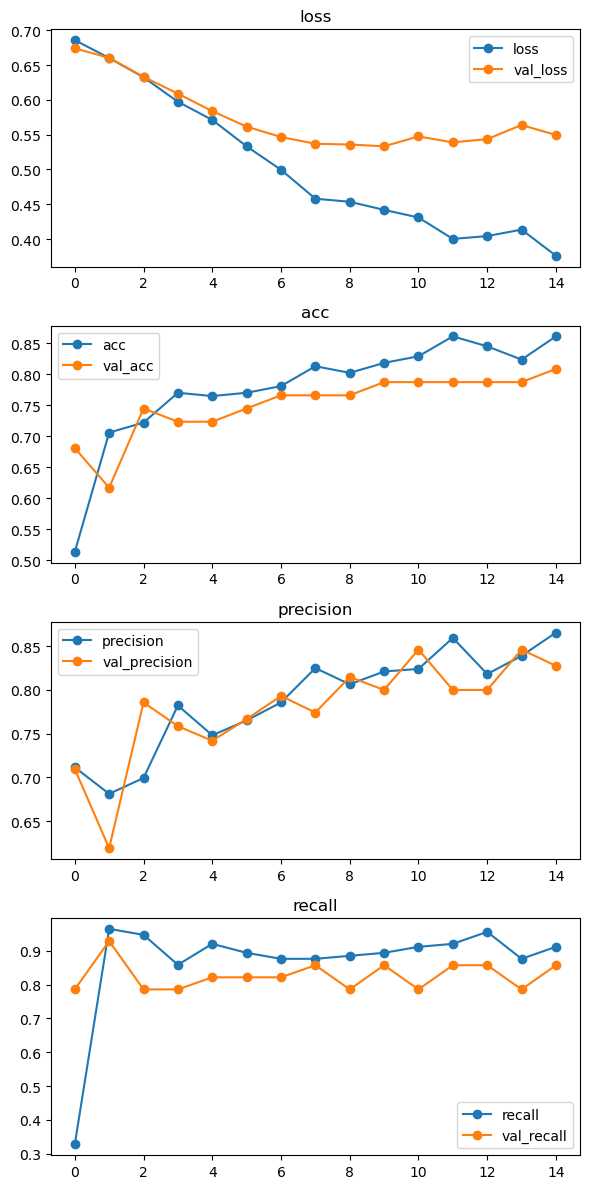

In [11]:
plot_history(history);

y_pred_test =  np.round(model1.predict(X_test_tf))
print(classification_report(y_test,y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, cmap='Blues', 
                                       normalize = 'true');

3/3 [==============================] - 0s 14ms/step
class_model2 Train 

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        93
           1       0.84      0.92      0.88       141

    accuracy                           0.85       234
   macro avg       0.85      0.83      0.83       234
weighted avg       0.85      0.85      0.84       234



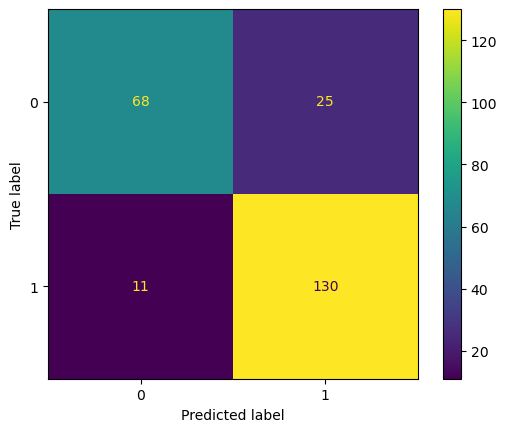

class_model2 Test 

              precision    recall  f1-score   support

           0       0.84      0.66      0.74        32
           1       0.79      0.91      0.85        46

    accuracy                           0.81        78
   macro avg       0.82      0.78      0.79        78
weighted avg       0.81      0.81      0.80        78



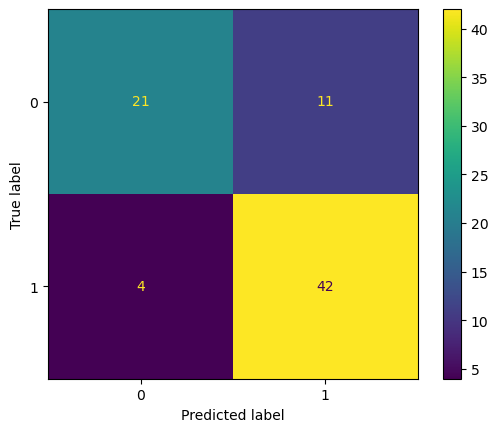

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
class_model2 Train,0.838710,0.921986,0.878378,0.846154
class_model2 Test,0.792453,0.913043,0.848485,0.807692


In [12]:
## Evaluate model

train_pred = np.rint(model1.predict(X_train_tf))
test_preds = np.rint(model1.predict(X_test_tf))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='class_model2 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='class_model2 Test')
scores = pd.concat([train_scores, test_scores])
scores

In [13]:
def build_model1(hp):
    model = Sequential()
    model.add(Dense(100, input_dim = input_shape, activation='relu'))
    model.add(Dense(units=hp.Int('units', min_value=10,max_value=75,step=5),
                                 activation='relu'))
    model.add(Dropout(hp.Float(name='dropout_value',min_value=.0,
                                    max_value=.5,step=.1)))
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5),
                                 activation = 'relu'))
    model.add(Dropout(hp.Float(name='dropout_value',min_value=.0,
                                    max_value=.5,step=.1)))
    model.add(Dense(units=hp.Int('units',min_value=10,max_value=25,step=5),
                                activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))

    model.compile(optimizer = hp.Choice('optimizer',['rmsprop', 'nadam', 'adam']),
                  loss ='bce', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
    return model

In [14]:
import os
folder = 'KerasTuner/'
os.makedirs(folder,exist_ok=True)

In [15]:
tuner = kt.Hyperband(build_model1, objective = 'val_accuracy', max_epochs=10,
                    directory=folder, overwrite = True, seed = 42, 
                    project_name = 'P4.3_tuning')

In [19]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
tuner.search(X_train_tf,y_train,epochs=50, validation_data=.2, 
             callbacks = [early_stop])


Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
70                |50                |units
0                 |0                 |dropout_value
adam              |nadam             |optimizer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.6883 - acc: 0.5812 - precision: 0.6617 - recall: 0.6241      

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tu

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/tensorflow/python/framework/tensor_shape.py", line 957, in __getitem__
    return self._dims[key]
IndexError: tuple index out of range


In [17]:
best_hps= tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 50,
 'dropout_value': 0.0,
 'optimizer': 'nadam',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [18]:
best_model = tuner.get_best_models()[0]
best_model.summary()

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for KerasTuner/P4.3_tuning/trial_0000/checkpoint

In [24]:
tuner.shape

AttributeError: 'Hyperband' object has no attribute 'shape'

In [ ]:
result = best_model.evaluate(X_test_tf, y_test, retrun_dict=True)
result

In [ ]:
tuner.results_summary(5)